In [1]:
from functools import partial
import os
import hydra
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from openretina.data_io.hoefling_2024.constants import FRAME_RATE_MODEL
from openretina.models.core_readout import CoreReadout
from openretina.insilico.stimulus_optimization.objective import ContrastiveNeuronObjective, SliceMeanReducer, IncreaseObjective
from openretina.insilico.stimulus_optimization.optimizer import optimize_stimulus
from openretina.insilico.stimulus_optimization.optimization_stopper import OptimizationStopper
from openretina.utils.plotting import play_stimulus, plot_stimulus_composition
from openretina.insilico.stimulus_optimization.regularizer import ChangeNormJointlyClipRangeSeparately

In [2]:
hydra.initialize(config_path=os.path.join("..", "configs"))
STIMULUS_SHAPE = (1, 2, 40, 18, 16)

/tmp/ipykernel_464547/4026950937.py:1: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path=os.path.join("..", "configs"))


Load the pretrained neural network hoefling 2024 trained on low resolution videos.

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CoreReadout.load_from_checkpoint(
    "/home/tzenkel/GitRepos/open-retina/models/hoefling_2024_base_low_res_model.ckpt",
    map_location=device)

Load the neural traces and the associated meta information based on the config of the model, and then extract the RGC group assignment for every neuron included in the model.

In [4]:
# Load config
cfg = hydra.compose(config_name="hoefling_2024_core_readout_low_res.yaml")
cfg.data.root_dir = os.path.join("..", "openretina_cache_folder")
# Load neuron data dict containing traces and all meta information that was used to train the neural network
neuron_data_dict = hydra.utils.call(cfg.data_io.responses.data_dict)

# extract group assignments for each readout 
group_assignment = np.concatenate([neuron_data_dict[k]["group_assignment"] for k in model.readout.readout_keys()])
type_to_idc = {int(t): np.where(group_assignment == t)[0].tolist() for t in set(group_assignment)}

Loading HDF5 file contents:   0%|          | 0/2077 [00:00<?, ?item/s]

Original dataset contains 7863 neurons over 67 fields
 ------------------------------------ 
Dropped 0 fields that did not contain the target cell types (67 remaining)
Overall, dropped 3034 neurons of non-target cell types (-38.59%).
 ------------------------------------ 
Dropped 0 fields with quality indices below threshold (67 remaining)
Overall, dropped 980 neurons over quality checks (-20.29%).
 ------------------------------------ 
Dropped 0 fields with classifier confidences below 0.25
Overall, dropped 705 neurons with classifier confidences below 0.25 (-18.32%).
 ------------------------------------ 
 ------------------------------------ 
Final dataset contains 3144 neurons over 67 fields
Total number of cells dropped: 4719 (-60.02%)


Define a function that optimizes a stimulus based on an objective and then plots this optimized stimulus.

In [5]:
def optimize_and_plot_stimulus(objective) -> None:
    torch.manual_seed(40)
    stimulus = torch.randn(STIMULUS_SHAPE, requires_grad=True, device=device)
    stimulus_postprocessor = ChangeNormJointlyClipRangeSeparately(
        min_max_values=[(-0.6, 6.2), (-0.9, 6.2)],
        norm=30.0,
    )
    stimulus.data = stimulus_postprocessor.process(stimulus.data * 0.1)

    optimize_stimulus(
        stimulus,
        optimizer_init_fn=partial(torch.optim.SGD, lr=100.0),
        objective_object=objective,
        optimization_stopper=OptimizationStopper(max_iterations=10),
        stimulus_postprocessor=stimulus_postprocessor,
    )

    fig_axes_tuple = plt.subplots(2, 2, figsize=(7 * 3, 12))
    axes: np.ndarray = fig_axes_tuple[1]  # type: ignore

    stim_length = STIMULUS_SHAPE[2]
    plot_stimulus_composition(
        stimulus=stimulus[0].detach().cpu().numpy(),
        temporal_trace_ax=axes[0, 0],
        freq_ax=axes[0, 1],
        spatial_ax=axes[1, 0],
        highlight_x_list=[(stim_length-10,stim_length-1)],
    )
    return stimulus


Define two objective functions:
- objective_mei optimizes an most exciting stimulus such that cells of type 28 activate strongly.
- objective_mds optimizes a most discriminatory stimulus such that cells of type 28 activate strongly but minimizes the response of other on and off cells.

In [6]:
reducer = SliceMeanReducer(axis=0, start=10, length=10)

objective_mei = IncreaseObjective(
    model,
    neuron_indices=type_to_idc[28],
    data_key=None,
    response_reducer=reducer,
)

off_cell_idc = sum([type_to_idc[i] for i in range(1, 10)], [])
on_off_cell_idc = sum([type_to_idc[i] for i in range(10, 15)], [])
on_cell_idc = sum([type_to_idc[i] for i in range(15, 28)], [])
objective_mds = ContrastiveNeuronObjective(
    model, 
    on_cluster_idc=type_to_idc[28],
    off_cluster_idc_list=[on_cell_idc, off_cell_idc],  # [off_cell_idc, on_off_cell_idc, on_cell_idc],
    data_key=None,
    response_reducer=reducer,
    temperature=1.6,
)

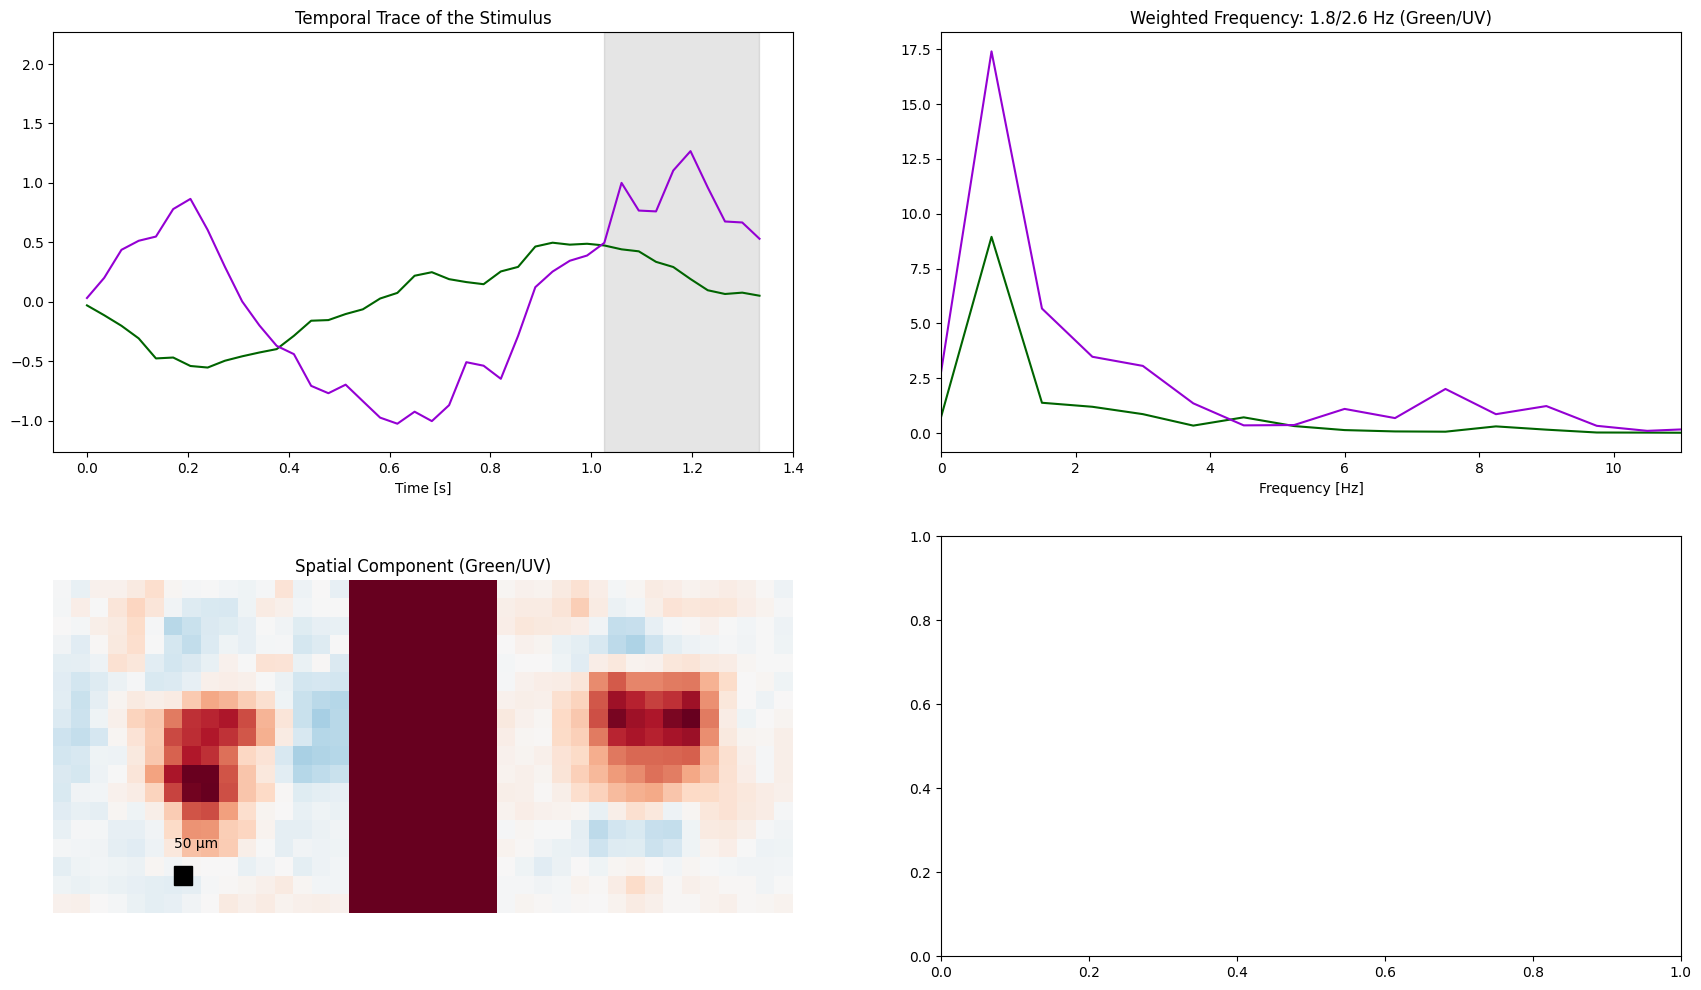

In [7]:
stimulus_mei = optimize_and_plot_stimulus(objective_mei)

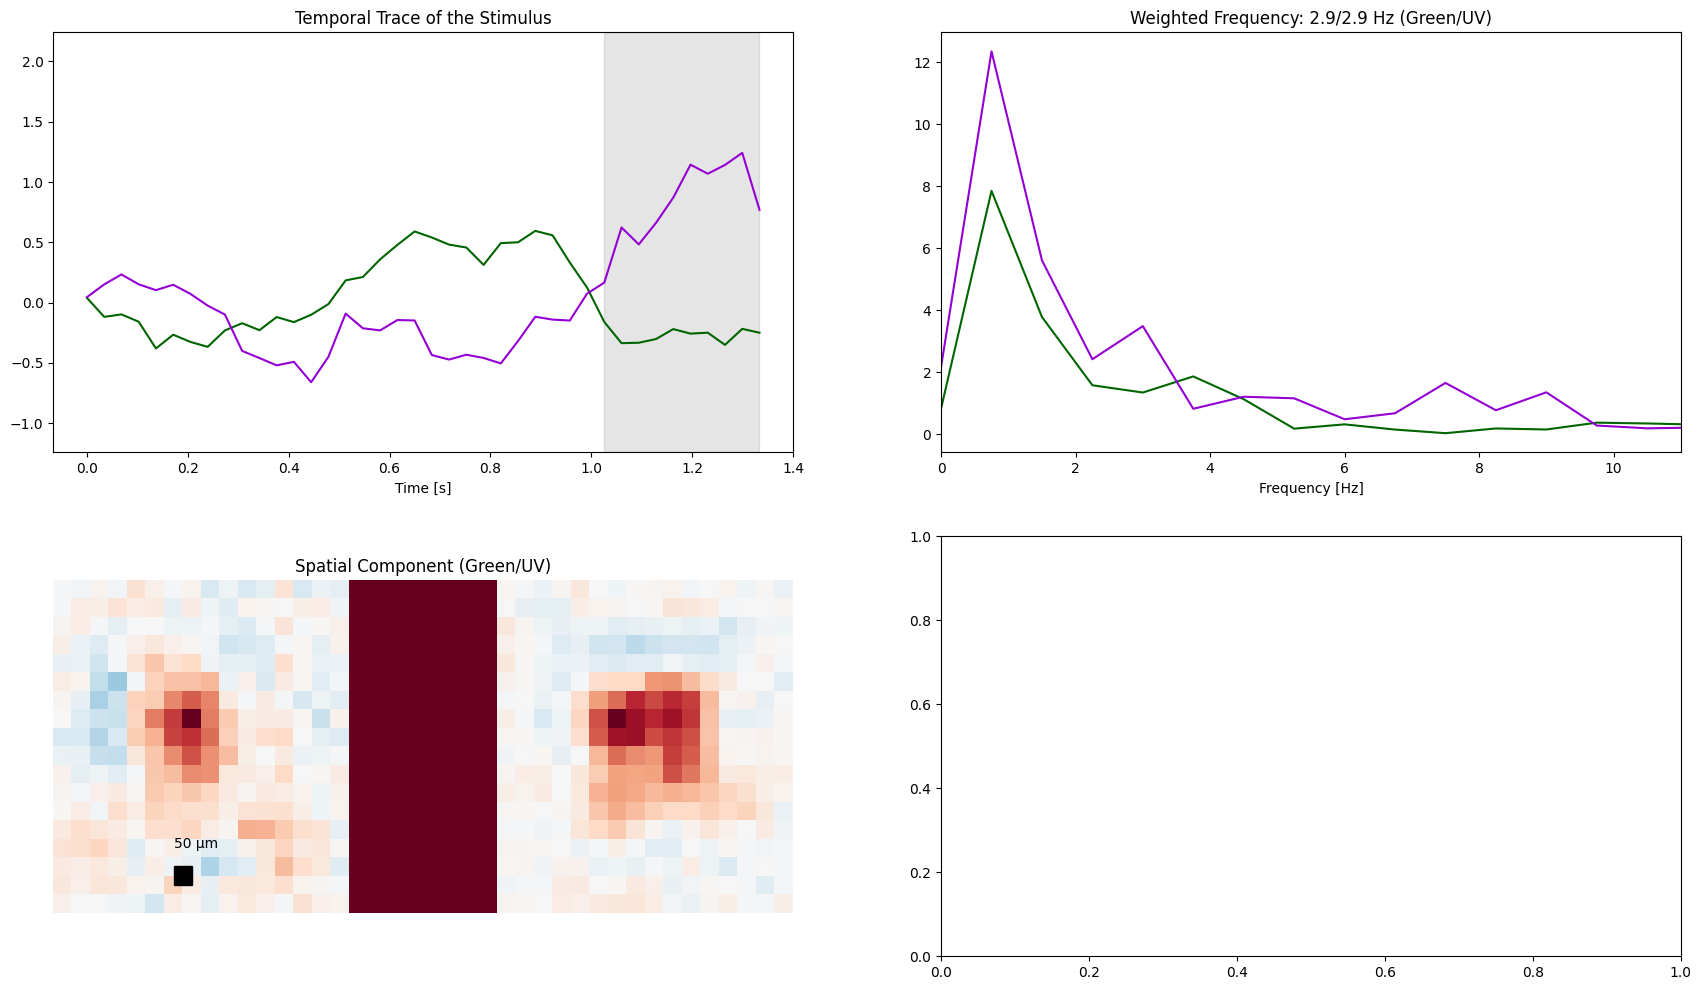

In [8]:
stimulus_mds = optimize_and_plot_stimulus(objective_mds)

We now use these stimuli and simulate the responses of the neural network.

In [9]:
responses_mds = model.forward(stimulus_mds)
responses_mds_np = responses_mds[0].detach().transpose(1, 0).numpy()
responses_mei = model.forward(stimulus_mei)
responses_mei_np = responses_mei[0].detach().transpose(1, 0).numpy()

For the MEI we see that the average response to neurons of group 28 is high, but the response of the other on cells is even higher.
In contrast, the average response of the on cells to the MDS stimulus is lower compared to the response of cells of group 28 cells.

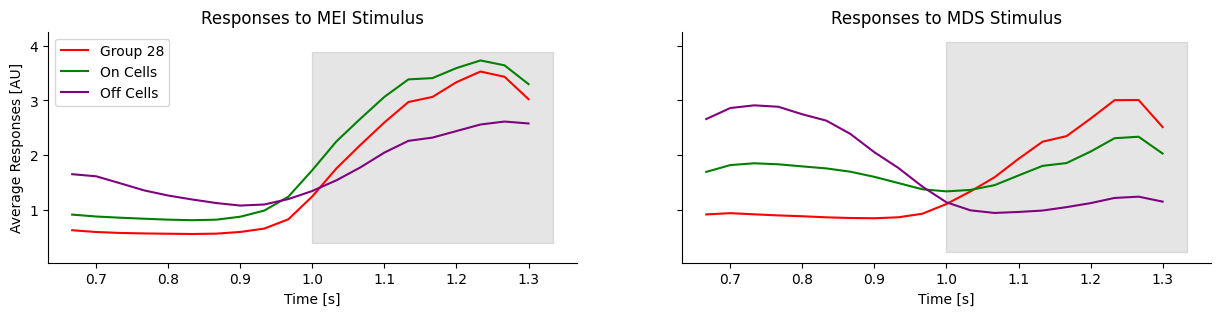

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3), sharey=True)

offset = 20
time = np.arange(offset, offset + responses_mds_np[0].shape[0]) / FRAME_RATE_MODEL
for ax, resp in zip(axes, [responses_mei_np, responses_mds_np]):
    ax.plot(time, resp[type_to_idc[28]].mean(axis=0), label="Group 28", color="red")
    ax.plot(time, resp[on_cell_idc].mean(axis=0), label="On Cells", color="green")
    ax.plot(time, resp[off_cell_idc].mean(axis=0), label="Off Cells", color="purple")
    ax.set_xlabel("Time [s]")
    ax.fill_betweenx(
        ax.get_ylim(), 
        (offset + reducer.start) / FRAME_RATE_MODEL, 
        (offset + reducer.start + reducer.length) / FRAME_RATE_MODEL, 
        color="k", alpha=0.1
    )
    
axes[0].set_title("Responses to MEI Stimulus")
axes[1].set_title("Responses to MDS Stimulus")
axes[0].set_ylabel("Average Responses [AU]")
axes[0].legend()
sns.despine()